In [1]:
%load_ext autoreload
%autoreload 2
import os,sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch.nn.functional import conv1d
import time 

# add project root dir to sys.path so that all packages can be found by python.
root_dir = os.path.dirname(os.path.realpath("__file__"))
sys.path.append(root_dir)
import data.utils as data_utils
import model.utils as model_utils
from test import predict_song, predict
from model.waveunet_params import waveunet_params
from MS2.train_apply import _create_waveunet
from data.viz import play_audio, plot_specgram
import tempfile
import librosa
import museval
from MS1.load_data import load_data
from test import evaluate
from tqdm import tqdm


In [2]:
args = waveunet_params.get_defaults()
args.instruments = ["accompaniment", "vocals"]
args.sr = 22050
args.channels = 1
model = _create_waveunet(args)
exp4 = "checkpoints/waveunet/best_checkpoint"
state = model_utils.load_model(model=model, optimizer=None, path=exp4, cuda=False)


Using valid convolutions with 53929 inputs and 44377 outputs
model:  Waveunet(
  (waveunets): ModuleDict(
    (accompaniment): Module(
      (downsampling_blocks): ModuleList(
        (0): DownsamplingBlock(
          (pre_shortcut_convs): ModuleList(
            (0): ConvLayer(
              (filter): Conv1d(1, 32, kernel_size=(5,), stride=(1,))
              (norm): GroupNorm(4, 32, eps=1e-05, affine=True)
            )
          )
          (post_shortcut_convs): ModuleList(
            (0): ConvLayer(
              (filter): Conv1d(32, 64, kernel_size=(5,), stride=(1,))
              (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
            )
          )
          (downconv): Resample1d()
        )
        (1): DownsamplingBlock(
          (pre_shortcut_convs): ModuleList(
            (0): ConvLayer(
              (filter): Conv1d(64, 64, kernel_size=(5,), stride=(1,))
              (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
            )
          )
          (post_shortc

In [3]:
def predict_audio(args, audio_or_path, model):
    mix_sr = args.sr
    if (isinstance(audio_or_path, str)):
        mix_audio, mix_sr = data_utils.load(audio_or_path, sr=None, mono=False)
        mix_channels = mix_audio.shape[0]
        mix_len = mix_audio.shape[1]
        # Adapt mixture channels to required input channels
        if args.channels == 1:
            mix_audio = np.mean(mix_audio, axis=0, keepdims=True)
        else:
            if mix_channels == 1: # Duplicate channels if input is mono but model is stereo
                mix_audio = np.tile(mix_audio, [args.channels, 1])
            else:
                assert(mix_channels == args.channels)
    else:
        mix_audio = audio_or_path
        mix_channels = mix_audio.shape[0]
        mix_len = mix_audio.shape[1]

    
    # resample to model sampling rate
    mix_audio = data_utils.resample(mix_audio, mix_sr, args.sr)
    sources = predict(mix_audio, model)
    # In case we had to pad the mixture at the end, or we have a few samples too many due to inconsistent down- and upsamṕling, remove those samples from source prediction now
    for key in sources.keys():
        diff = sources[key].shape[1] - mix_len
        if diff > 0:
            print("WARNING: Cropping " + str(diff) + " samples")
            sources[key] = sources[key][:, :-diff]
        elif diff < 0:
            print("WARNING: Padding output by " + str(diff) + " samples")
            sources[key] = np.pad(sources[key], [(0,0), (0, -diff)], "constant", 0.0)

    return sources

def seperate_youtube_audio(url, args, model):
    temp_dir = tempfile.TemporaryDirectory()
    #download audio file in temp dir
    audio_path = pytube.YouTube(url).streams.filter(only_audio=True).first().download(temp_dir.name)
    y, _ = librosa.load(audio_path, sr=args.sr) #load original
    results = predict_audio(args, audio_path, model)
    temp_dir.cleanup()
    original = np.expand_dims(y, 0)
    return original, results

def seperate_local_audio(audio_path, args, model):
    y, _ = librosa.load(audio_path, sr=args.sr) #load original
    results = predict_audio(args, audio_path, model)
    return y, results

def play_and_visualize(audio, args, model, start=30, duration=5, title="Spectogram"):
    start_frame = start*args.sr 
    end_frame = start_frame + duration*args.sr
    original = audio[: ,start_frame:end_frame]
    play_audio(original, args.sr)
    plot_specgram(original, args.sr, title)
    
def_window_secs = 2
def_hop_secs = 1.5

def compute_residue(mixture_audio, vocals_audio, accompaniment_audio, 
                 window_secs = def_window_secs, hop_secs = def_hop_secs):
    # Residual energy after substracting predicted sources
    residual = (mixture_audio - (vocals_audio + accompaniment_audio))**2
    sr = args.sr 
    conv_input = torch.from_numpy(np.expand_dims(residual,0)).float()
    conv_kernel = torch.ones([1,1,round(window_secs*sr)])
    residual_t = conv1d(conv_input,conv_kernel, 
                        stride=round(hop_secs*sr), padding='valid').squeeze()
    return residual_t


def compute_snr(mixture_audio, vocals_audio, accompaniment_audio, 
                 window_secs = def_window_secs, hop_secs = def_hop_secs):
    # Signal-To-Noise-Ratio
    noise_energy = (mixture_audio - (vocals_audio + accompaniment_audio))**2
    signal_energy = mixture_audio**2
    sr = args.sr 
    conv_kernel = torch.ones([1,1,round(window_secs*sr)])

    signal_power = conv1d(torch.from_numpy(np.expand_dims(signal_energy,0)).float(),conv_kernel, 
                         stride=round(hop_secs*sr), padding='valid').squeeze() 
    noise_power = conv1d(torch.from_numpy(np.expand_dims(noise_energy,0)).float(),conv_kernel, 
                         stride=round(hop_secs*sr), padding='valid').squeeze()
    epsilon = 1e-6
    snr = 10*(np.log10(signal_power+epsilon) - np.log10(noise_power+epsilon))
    return snr

def retrieve_metrics(target_sources, pred_sources, window_secs = def_window_secs, hop_secs = def_hop_secs,
                     instruments=["vocals", "accompaniment"]):
    SDR, ISR, SIR, SAR, _ = museval.metrics.bss_eval(
        target_sources, pred_sources, window=window_secs*args.sr, hop=hop_secs*args.sr)
    song = {}
    for idx, name in enumerate(instruments):
        song[name] = {"SDR" : SDR[idx], "ISR" : ISR[idx], "SIR" : SIR[idx], "SAR" : SAR[idx]}
    return song

def plot_metrics_vs_residual(metrics, residual, instruments=["vocals", "accompaniment"], 
                             metric_names=["SDR","ISR","SIR","SAR"]):
    color=['blue','red','green','magenta','black']
    assert(residual.shape[0] == metrics[instruments[0]][metric_names[0]].shape[0])
    num_metrics = len(metric_names)
    num_instruments = len(instruments)
    fig,axes = plt.subplots(num_metrics,1, figsize=(10,10*num_metrics))
#     fig.tight_layout()
#     fig.subplots_adjust(wspace=0.2)
#     ax = axes[0]
#     ax.plot(metric, color="red", marker="o")
#     ax.set_ylabel(metric_name,color="red",fontsize=14)
#     ax2=ax.twinx()
#     ax2.plot(residual,color="blue",marker="o")
#     ax2.set_ylabel("Residual",color="blue",fontsize=14)

    for i in range(num_metrics):
        ax = axes[i]
        metric_name = metric_names[i]
        for j in range(num_instruments):
            instr_name = instruments[j]
            metric = metrics[instr_name][metric_name]
            corr_coeff = np.corrcoef(np.nan_to_num(metric),  residual)[0,1]
            print(f"Corr. coeff {metric_name},{instr_name} = {corr_coeff}")
            ax.scatter(metric, residual, c=color[j],label=instr_name)
        ax.set_xlabel(metric_name)
        ax.set_ylabel("Residual")
        ax.legend()

    plt.show()
        
def compute_metrics_and_residual(mix, targets):
    prediction = predict_audio(args, mix.detach().cpu().numpy(), model)
    target_sources = np.stack([targets['vocals'], targets['accompaniment']]).squeeze()
    pred_sources = np.stack([prediction["vocals"], prediction["accompaniment"]]).squeeze()
    metrics = retrieve_metrics(target_sources, pred_sources)
    residual = compute_residue(mix, prediction["vocals"], prediction["accompaniment"])
    return metrics, residual

def plot_metrics_vs_snr(metrics, snr, instruments=["vocals", "accompaniment"], 
                        metric_names=["SDR","ISR","SIR","SAR"]):
    color=['blue','red','green','magenta','black']
    assert(snr.shape[0] == metrics[instruments[0]][metric_names[0]].shape[0])
    num_metrics = len(metric_names)
    num_instruments = len(instruments)
    fig,axes = plt.subplots(num_metrics,1, figsize=(10,10*num_metrics))

    for i in range(num_metrics):
        ax = axes[i]
        metric_name = metric_names[i]
        for j in range(num_instruments):
            instr_name = instruments[j]
            metric = metrics[instr_name][metric_name]
            corr_coeff = np.corrcoef(np.nan_to_num(metric),  snr)[0,1]
            print(f"Corr. coeff {metric_name},{instr_name} = {corr_coeff}")
            ax.scatter(metric, snr, c=color[j],label=instr_name)
        ax.set_xlabel(f'{metric_name} (dB)')
        ax.set_ylabel("SNR (dB)")
        ax.legend()

    plt.show()
    
def compute_metrics_and_snr(mix, targets):
    prediction = predict_audio(args, mix.detach().cpu().numpy(), model)
    target_sources = np.stack([targets['vocals'], targets['accompaniment']]).squeeze()
    pred_sources = np.stack([prediction["vocals"], prediction["accompaniment"]]).squeeze()
    metrics = retrieve_metrics(target_sources, pred_sources)
    snr = compute_snr(mix, prediction["vocals"], prediction["accompaniment"])
    return metrics, snr, prediction


In [7]:
y, _ = librosa.load("sample/vocals.wav", sr=args.sr)
vocals_audio = np.expand_dims(y, 0)
y, _ = librosa.load("sample/accompaniment.wav", sr=args.sr)
accompaniment_audio = np.expand_dims(y, 0)
mixture_audio, local_results = seperate_local_audio("sample/mixture.wav", args, model)

In [10]:
target_sources = np.stack([vocals_audio, accompaniment_audio]).squeeze()
pred_sources = np.stack([local_results["vocals"], local_results["accompaniment"]]).squeeze()
metrics = retrieve_metrics(target_sources, pred_sources)

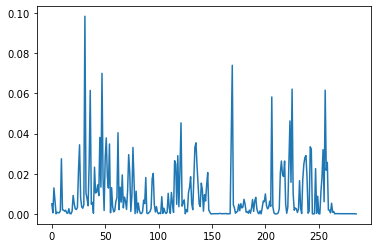

In [28]:
residual = compute_residue(mixture_audio, local_results["vocals"], local_results["accompaniment"])
plt.plot(residual)


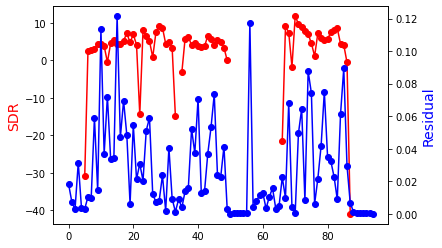

Correlation coefficients = [[1.         0.25466558]
 [0.25466558 1.        ]]


In [29]:
plot_metrics_vs_residual(metrics, residual, "vocals", "SDR")

In [4]:
train_set, test_set = load_data(datasets_path='data')
mix, targets = test_set[0]


Loading train set...
Loading test set...
Loading train set...
Loading test set...


Corr. coeff SDR,vocals = 0.26228774157367507
Corr. coeff SDR,accompaniment = -0.37023083478291763
Corr. coeff ISR,vocals = 0.3639928872531491
Corr. coeff ISR,accompaniment = -0.05518873255554629
Corr. coeff SIR,vocals = 0.4708281147670588
Corr. coeff SIR,accompaniment = -0.4605780514994408
Corr. coeff SAR,vocals = 0.36085979721901373
Corr. coeff SAR,accompaniment = -0.1369404045017281


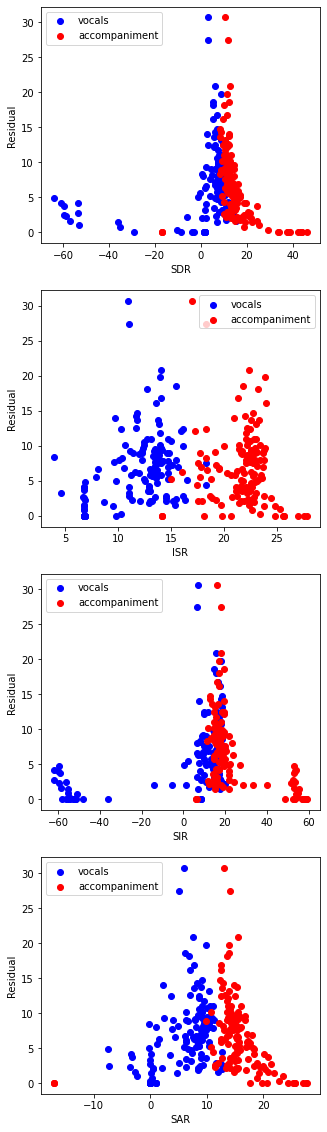

In [175]:
metrics, residual = compute_metrics_and_residual(mix, targets)
plot_metrics_vs_residual(metrics, residual)

Corr. coeff SDR,vocals = -0.10792000439593906
Corr. coeff SDR,accompaniment = 0.946795899474427
Corr. coeff ISR,vocals = -0.17662864204263112
Corr. coeff ISR,accompaniment = 0.583462925119529
Corr. coeff SIR,vocals = -0.5138471942969793
Corr. coeff SIR,accompaniment = 0.6469087370639027
Corr. coeff SAR,vocals = -0.1784483730081816
Corr. coeff SAR,accompaniment = 0.8756117882674576


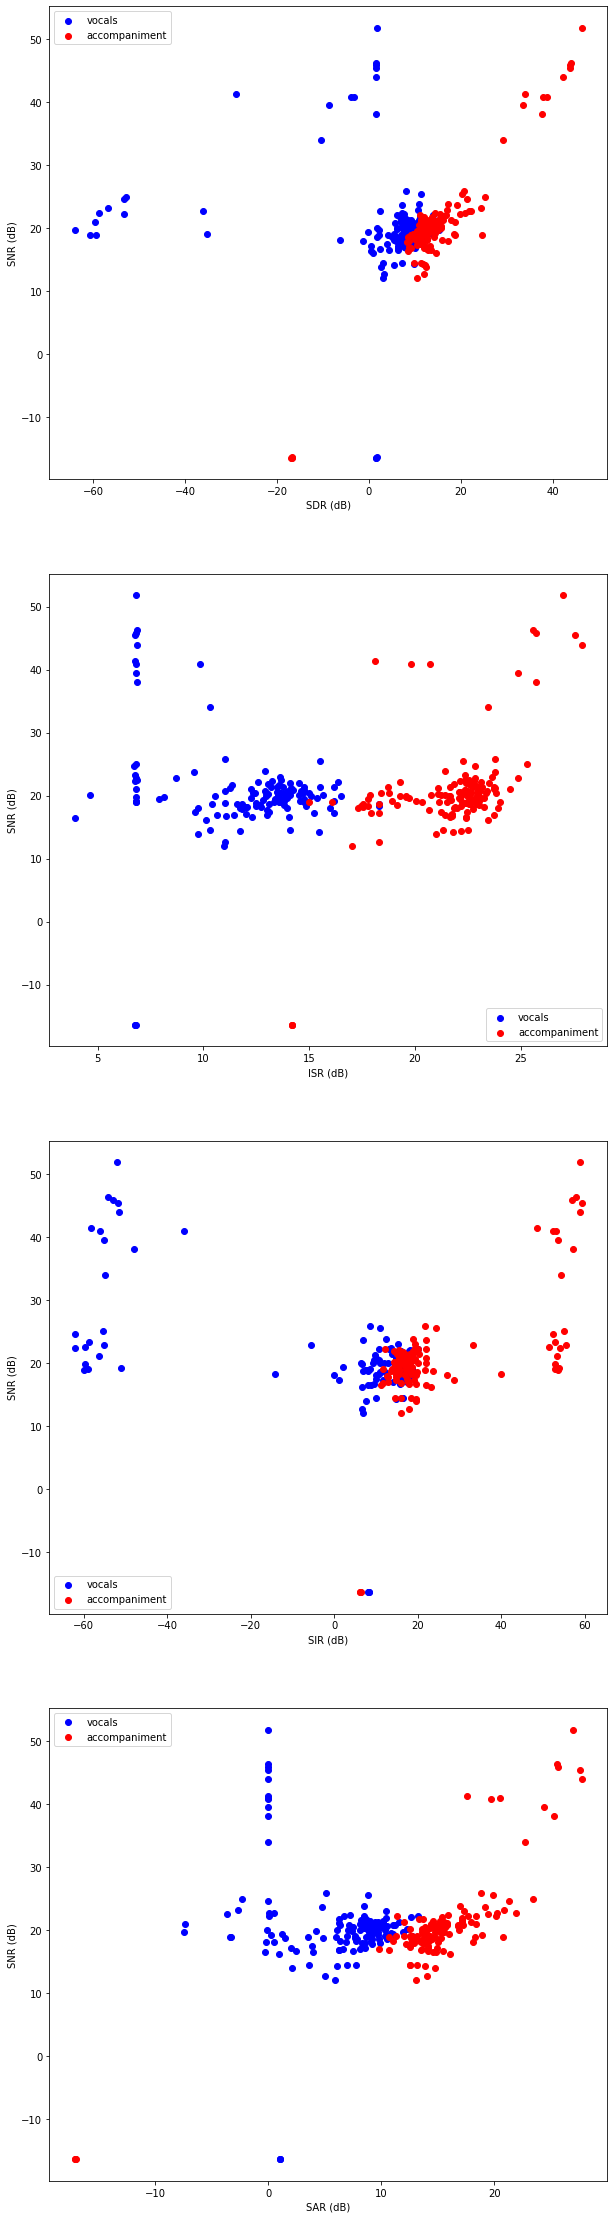

In [10]:
metrics, snr = compute_metrics_and_snr(mix, targets)
plot_metrics_vs_snr(metrics, snr)

In [5]:
metrics, snr, prediction = compute_metrics_and_snr(mix, targets)

# Use a logistic sigmoid to normalize SNR values to range [0,1]:
# confidence = 1/(1 + e^(-k(x - mid_snr))).
# Steepness and midpoint are empirically chosen based on results from MUSDB dataset.
k = 0.15; # Steepness of the curve.
mid_snr = 15; # SNR (dB) at which the confidence is 0.5.
confidence =  1. / (1. + np.exp(-k*(snr - mid_snr)))

y: (1, 4628480), hop_length: 22
y: (1, 4628480), hop_length: 22
y: (1, 4628480), hop_length: 22


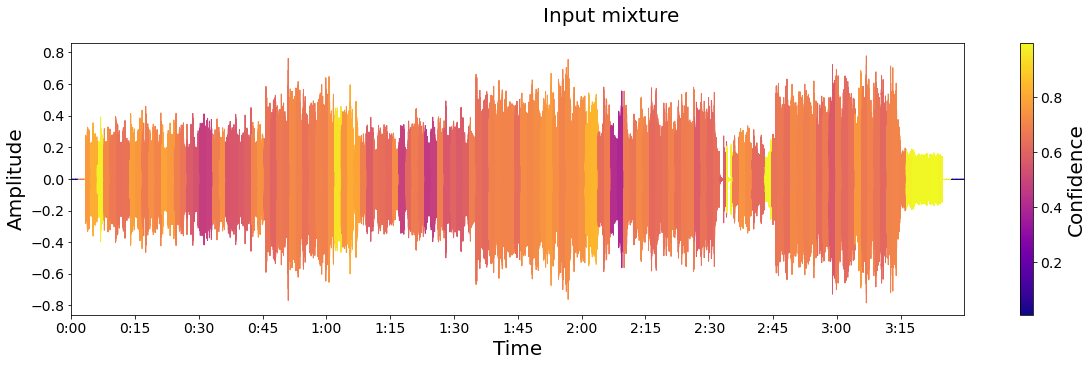

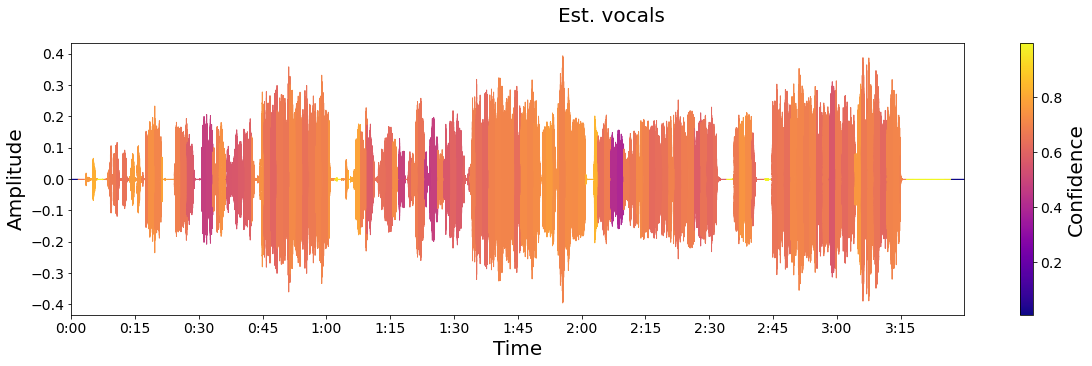

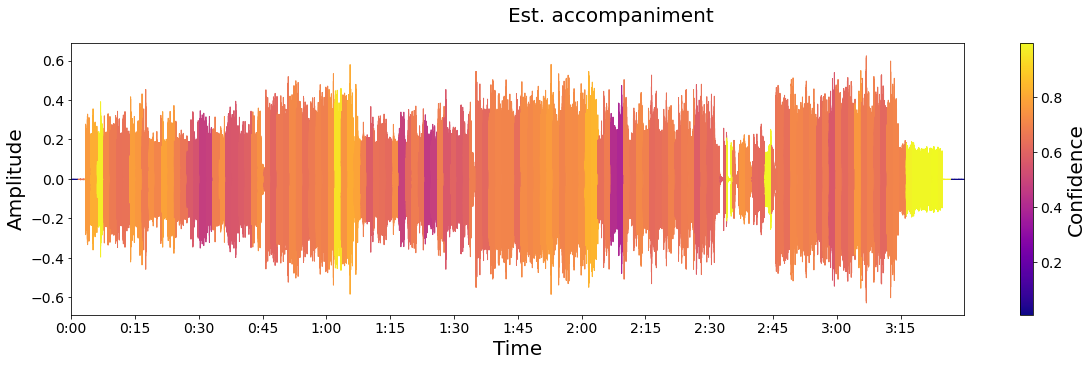

In [10]:
from matplotlib.ticker import MaxNLocator
from librosa.display import TimeFormatter, __envelope
from librosa.util import frame
from librosa import core
from  matplotlib import colors

def conf_plot(y, title):
    if y.ndim == 1:
        y = y[np.newaxis, :]
        
    fig, ax = plt.subplots(figsize=(20, 5))
    fig.suptitle(title, fontsize=20)
    
    sr = args.sr
    target_sr = 1000
    hop_length = sr // target_sr

    # axis formatting
    ax.xaxis.set_major_formatter(TimeFormatter(unit=None, lag=False))
    ax.xaxis.set_major_locator(MaxNLocator(nbins='auto', prune=None, steps=[1, 1.5, 5, 6, 10], min_n_ticks=10))
    ax.tick_params(labelsize=14)
    
    ax.set_xlabel('Time', fontsize = 20)
    ax.set_ylabel('Amplitude', fontsize = 20)
    
    print(f'y: {y.shape}, hop_length: {hop_length}')

    y= np.abs(frame(y, frame_length=hop_length, hop_length=hop_length)).max(axis=1)
    y_top = y[0]
    y_bottom = -y[-1]

    x =  core.times_like(y_top, sr=args.sr, hop_length=hop_length)
    ax.set_xlim([x.min(), x.max()])

    norm = colors.Normalize(vmin=confidence.min(), vmax=confidence.max())
    cmap = plt.cm.get_cmap('plasma')

    num_windows = len(confidence)
    win_length = mix.shape[1] / num_windows
    num_points_win = int(win_length // hop_length)

    for i in range(num_windows):
        plt.fill_between(x[i*num_points_win:(i+1)*num_points_win], y_bottom[i*num_points_win:(i+1)*num_points_win], 
                         y_top[i*num_points_win:(i+1)*num_points_win], color=cmap(norm(confidence[i])))
    cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='vertical', label='Confidence')
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.yaxis.get_label().set_fontsize(20)

conf_plot(mix.detach().cpu().numpy(), "Input mixture")
conf_plot(prediction['vocals'].squeeze(), "Est. vocals")
conf_plot(prediction['accompaniment'].squeeze(), "Est. accompaniment")






In [188]:
instruments = ['vocals', 'accompaniment']
metric_names = ["SDR","ISR","SIR","SAR"]
total_metrics = None
total_residual = []
for sample in tqdm(test_set):
    mix, targets = sample
    metrics, residual = compute_metrics_and_residual(mix, targets)
    if (total_metrics is None):
        total_metrics = metrics
    else:
        for inst in instruments:
            for metric in metric_names:
                total_metrics[inst][metric] = np.append(total_metrics[inst][metric], metrics[inst][metric])
    total_residual = np.append(total_residual, residual)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [55:47<00:00, 66.95s/it]


Corr. coeff SDR,vocals = 0.028437953160788915
Corr. coeff SDR,accompaniment = -0.0932614236939447
Corr. coeff ISR,vocals = 0.22414018081146284
Corr. coeff ISR,accompaniment = 0.04781292726295683
Corr. coeff SIR,vocals = 0.12400870718358863
Corr. coeff SIR,accompaniment = -0.02664116130576678
Corr. coeff SAR,vocals = 0.1458834921703236
Corr. coeff SAR,accompaniment = -0.016881787887260205


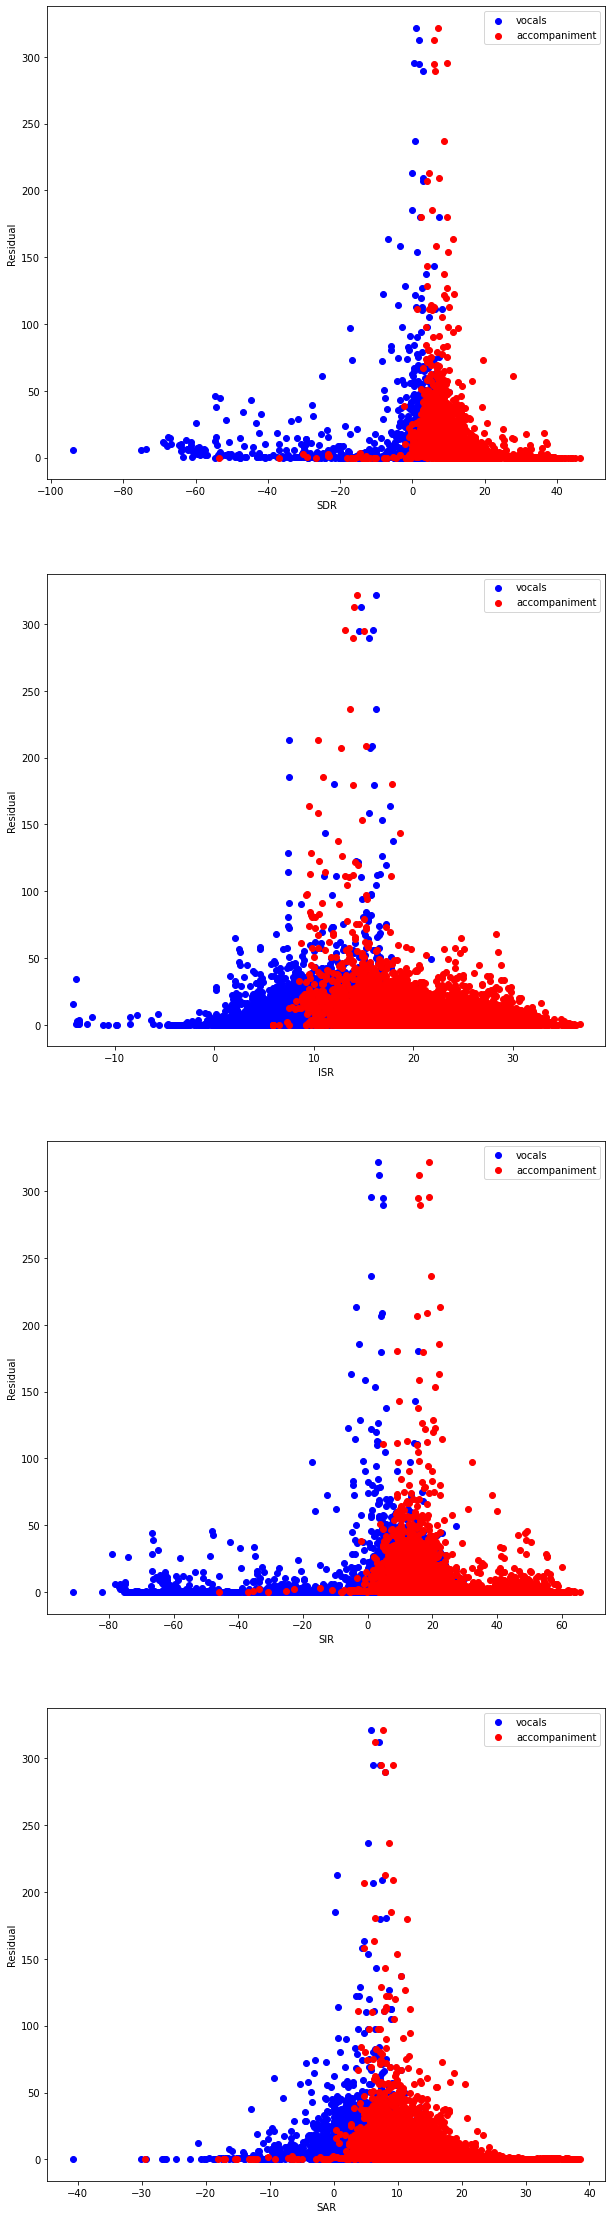

In [189]:
plot_metrics_vs_residual(total_metrics, total_residual)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [52:27<00:00, 62.95s/it]


Corr. coeff SDR,vocals = -0.17230515532420126
Corr. coeff SDR,accompaniment = 0.20040114173659543
Corr. coeff ISR,vocals = -0.3922699058329273
Corr. coeff ISR,accompaniment = -0.17962213534593532
Corr. coeff SIR,vocals = -0.401501981510057
Corr. coeff SIR,accompaniment = 0.14490650094352914
Corr. coeff SAR,vocals = -0.3249549771609306
Corr. coeff SAR,accompaniment = 0.05156291167927346


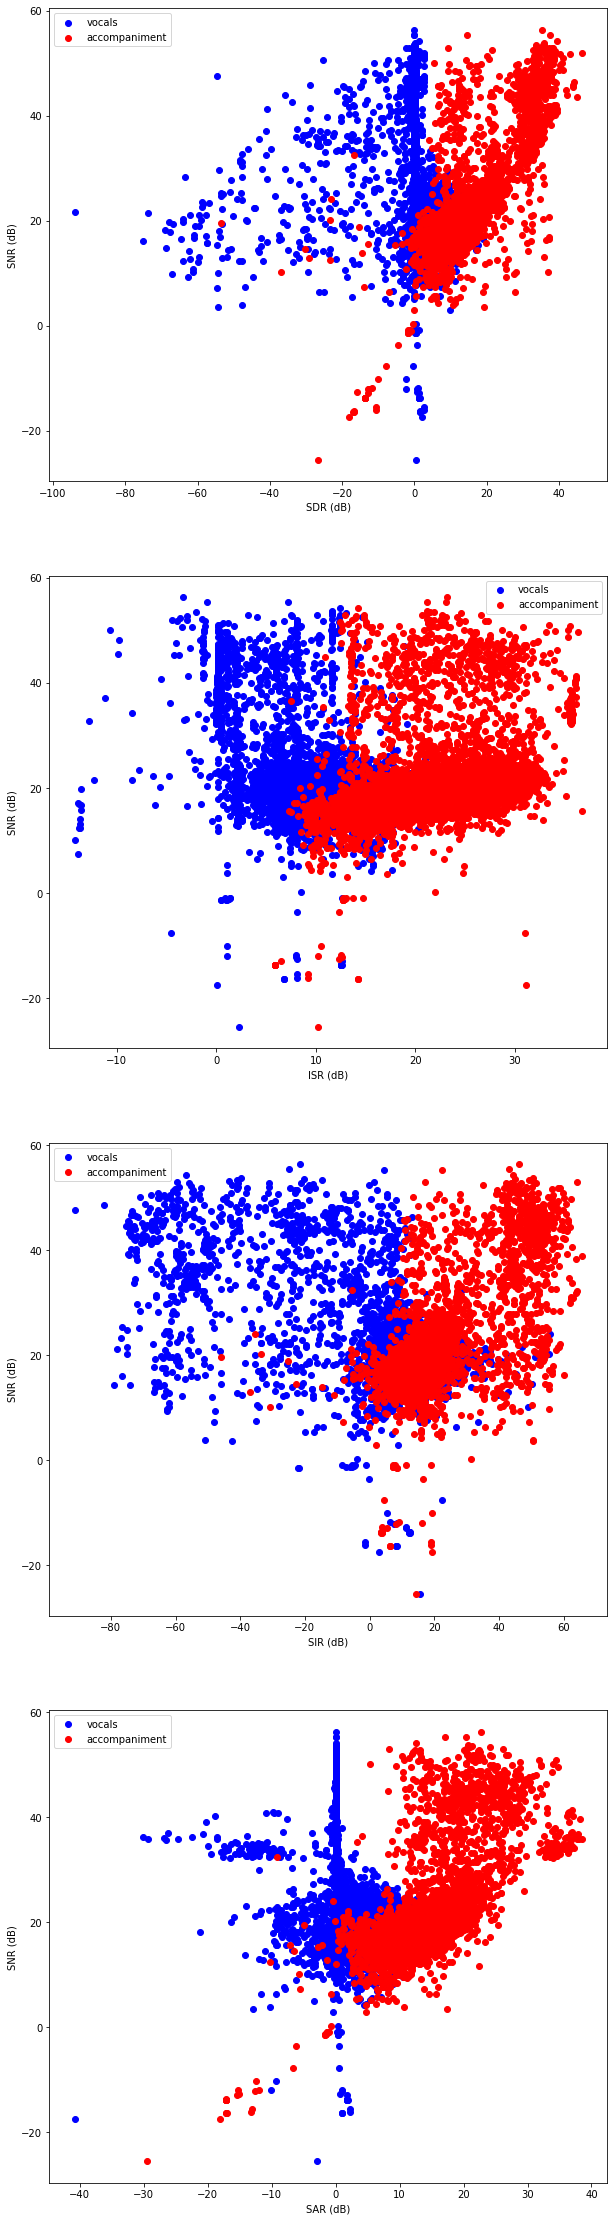

In [5]:
instruments = ['vocals', 'accompaniment']
metric_names = ["SDR","ISR","SIR","SAR"]
total_metrics = None
total_snr = []
for sample in tqdm(test_set):
    mix, targets = sample
    metrics, snr = compute_metrics_and_snr(mix, targets)
    if (total_metrics is None):
        total_metrics = metrics
    else:
        for inst in instruments:
            for metric in metric_names:
                total_metrics[inst][metric] = np.append(total_metrics[inst][metric], metrics[inst][metric])
    total_snr = np.append(total_snr, snr)
plot_metrics_vs_snr(total_metrics, total_snr)